In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
from function import fun1,fun2,fun3,fun4,fun5,fun6,fun7
from my_NN import *
import os
import matplotlib.pyplot as plt
import ycx_para_config as ycx

# 确保 model 文件夹存在
os.makedirs('./model_parameter', exist_ok=True)

debug=False
use_multi_path_boundary_loss=ycx.use_multi_path

loss_list_final=[]

In [2]:
def sample_t_per_interval_and_generate_f_start(dtype,device,seg_step=16,batch_size=32,f_start_min=0.1,f_start_max=0.9):
    t_seg=torch.linspace(0,1,seg_step+1,dtype=dtype,device=device)
    t_seg=t_seg.repeat(batch_size,1)
    
    rand_move=torch.empty((batch_size,seg_step+1),dtype=dtype,device=device).uniform_(-ycx.random_amplititude/seg_step,ycx.random_amplititude/seg_step)
    rand_move[:,0]=0
    rand_move[:,-1]=0
    
    t_seg+=rand_move
    f_start_rand=torch.empty((batch_size,1),dtype=dtype,device=device).uniform_(f_start_min,f_start_max)
    
    return t_seg , f_start_rand


In [3]:
def boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=fun1,f_start_min=0.1,f_start_max=0.9):
    #注意这里t_seg还是size为(batch_size,seg_step+1)的tensor
    t_seg_copy=t_seg.clone()
    t_seg_copy=t_seg_copy.unsqueeze_(-1)
    temp_loss_list=[]
    
    log_step=int(np.log2(seg_step))
    
    delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
    func_f_end_value=boundary_func(f_start_rand)
    
    model_f_end_value=f_start_rand
    for i in range(seg_step):
        model_f_end_value=model_f_end_value + delta[:,i] * model.forward(model_f_end_value,t_seg_copy[:,i],delta[:,i])
        
    boundary_loss=loss_func(model_f_end_value,func_f_end_value)
    temp_loss_list.append(boundary_loss.item())  

    if debug:
        print('\nboundary_loss max step:',boundary_loss.item())  
    ##############################
    if use_multi_path_boundary_loss:
        temp_step=seg_step
        if debug:print('log_step:',log_step)
        for i in range(log_step):
            t_seg_copy=t_seg_copy[:,::2]
            temp_step=temp_step//2
            delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
            model_f_end_value=f_start_rand
            for j in range(temp_step):
                model_f_end_value=model_f_end_value + delta[:,j] * model.forward(model_f_end_value,t_seg_copy[:,j],delta[:,j])
            if debug:print(f'step_boundary_loss steplen {2**(i+1)}:',loss_func(model_f_end_value,func_f_end_value).item())
            
            temp_loss_list.append(loss_func(model_f_end_value,func_f_end_value).item())
            
            boundary_loss+=loss_func(model_f_end_value,func_f_end_value)
            
        loss_list_final.append(temp_loss_list)
        if debug:print('boundary_loss:',boundary_loss.item())
    return boundary_loss
    

In [4]:
def consist_loss_calculator(model,t_seg,seg_step,loss_func,batch_size,boundary_func,f_start_min,f_start_max):
    t_seg_copy=t_seg.clone()
    dtype=t_seg.dtype
    device=t_seg.device
    t_seg_copy=t_seg_copy.unsqueeze_(-1)
    consist_loss=0
    
    max_step_len=seg_step//2
    
    for t in range(1,max_step_len+1):
        end_num=seg_step-2*t
        if end_num<0:
            break
        #generate the f_0 value
        f_start_rand=torch.empty((batch_size,end_num+1),dtype=dtype,device=device).uniform_(f_start_min,f_start_max)
        f_start_rand=f_start_rand.unsqueeze(-1)
        #calculate the one step loss
        delta=t_seg_copy[:,2*t:]-t_seg_copy[:,:end_num+1]
        one_step_result=f_start_rand+delta*model.forward(f_start_rand,t_seg_copy[:,:end_num+1],delta)
        
        #calculate the two step loss
        delta_1=t_seg_copy[:,t:end_num+1+t]-t_seg_copy[:,:end_num+1]
        delta_2=t_seg_copy[:,2*t:]-t_seg_copy[:,t:end_num+1+t]
        two_step_result_one=f_start_rand+delta_1*model.forward(f_start_rand,t_seg_copy[:,:end_num+1],delta_1)
        two_step_result_two=two_step_result_one+delta_2*model.forward(two_step_result_one,t_seg_copy[:,t:end_num+1+t],delta_2)
        
        norm_factors=delta**2
        
        consist_loss+=loss_func(two_step_result_two/norm_factors,one_step_result/norm_factors)
    
    return consist_loss
        
    
    

In [5]:
def get_loss(model,loss_func,batch_size,seg_step,dtype,device,boundary_func=fun1,f_start_min=0.1,f_start_max=0.6,consist_depth=5):
    use_consist_loss=False
    
    t_seg,f_start_rand=sample_t_per_interval_and_generate_f_start(dtype=dtype,device=device,seg_step=seg_step,batch_size=batch_size,f_start_min=f_start_min,f_start_max=f_start_max)
    
    boundary_loss=boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=boundary_func,f_start_min=f_start_min,f_start_max=f_start_max)
    
    consist_loss=consist_loss_calculator(model,t_seg,seg_step,loss_func,batch_size,boundary_func,f_start_min,f_start_max)
    
    loss=boundary_loss+consist_loss
    
    return loss
    

In [6]:
def iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=5,boundary_func=fun1):
    #train_loop
    optimizer.zero_grad()
    #计算loss
    #这里可以调节seg_step，f_start_min,f_start_max
    loss=get_loss(model,loss_func,batch_size,seg_step=ycx.choose_seg_step,dtype=dtype,device=device,boundary_func=boundary_func,consist_depth=consist_depth,f_start_min=ycx.f_start_min,f_start_max=ycx.f_start_max)
    #反向传播
    loss.backward()
    #更新参数
    optimizer.step()
    return loss.item()

In [ ]:
def training(model,device='cuda',dtype=torch.float32,
          epoch=100,batch_size=32,lr=0.01,consist_depth=5,
          use_lr_scheduler=False,boundary_func=fun1):
    loss_list = []
    
    loss_func = nn.MSELoss()
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr,
                                 **({"fused": True} if "cuda" in str(device) else {}))#这里的fused=True，是为了使用apex加速

    # Use ReduceLROnPlateau as the learning rate scheduler
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               patience=ycx.lr_schedule_patience,
                                                               threshold=1e-4,
                                                               cooldown=ycx.lr_schedule_cooldown)
    
    init_time = time.time()
    for i in range(epoch):
        for _ in range(ycx.iteration_num):
            loss_term=iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=consist_depth,boundary_func=boundary_func)
            #设计中，iteration中已经完成反向传播，所以这里不需要再进行反向传播
            loss_list.append(loss_term)
        if (i+1)%20==0:
            print(f'epoch:{i+1},loss:{loss_term},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        if (i+1)%50==0:
            torch.save(model.state_dict(),ycx.consist_para_file_name)
        if use_lr_scheduler:
            scheduler.step(loss_term)
        if optimizer.param_groups[0]["lr"] <= 1.1e-8:
            break
    print('terminal epoch: ',i+1)
    torch.save(model.state_dict(),ycx.consist_para_file_name)
    
    if debug==False:
        plt.plot(loss_list,label='loss')
        plt.legend()
    pass

now using cuda !
epoch:20,loss:0.13205869495868683,time:0.8880515098571777,lr:0.01
epoch:40,loss:0.0562225878238678,time:1.5323195457458496,lr:0.01
epoch:60,loss:0.014974560588598251,time:2.178632974624634,lr:0.01
epoch:80,loss:0.002895690966397524,time:2.81295108795166,lr:0.01
epoch:100,loss:0.0021933196112513542,time:3.451594352722168,lr:0.01
epoch:120,loss:0.0017304840730503201,time:4.105133295059204,lr:0.01
epoch:140,loss:0.0016073464648798108,time:4.7561585903167725,lr:0.01
epoch:160,loss:0.0015903405146673322,time:5.4038567543029785,lr:0.01
epoch:180,loss:0.0015747998841106892,time:6.056123971939087,lr:0.01
epoch:200,loss:0.0015164875658228993,time:6.71368932723999,lr:0.01
epoch:220,loss:0.0014931443147361279,time:7.368073225021362,lr:0.01
epoch:240,loss:0.001306553604081273,time:8.008289575576782,lr:0.01
epoch:260,loss:0.000998122850432992,time:8.659553527832031,lr:0.01
epoch:280,loss:0.0007471744902431965,time:9.31353759765625,lr:0.01
epoch:300,loss:0.0006840253481641412,time:9

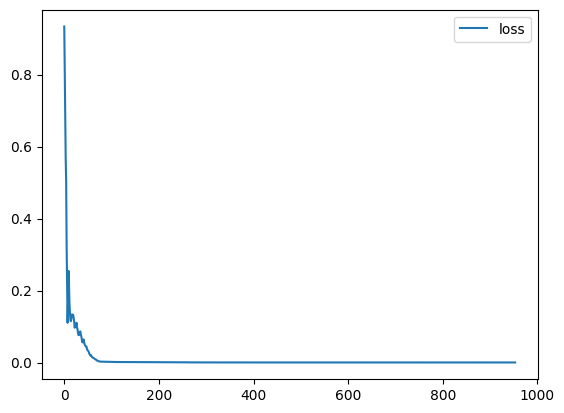

In [8]:
if __name__=='__main__':
    initial_time=time.time()
    if torch.cuda.is_available():
        device='cuda'
        print('now using cuda !')
    else:
        device='cpu'
        print('now using cpu !')
    dtype=torch.float32
    model=ycx.NN().to(device=device,dtype=dtype)
    #初始化网络参数
    from torch.nn import init
    for name, param in model.named_parameters():
        if 'weight' in name:
            init.normal_(param, mean=0, std=0.1)
        elif 'bias' in name:
            init.constant_(param, val=0)
            
    ############################################################
    #设置超参数
    batch_size=ycx.batch
    epoch=ycx.epoch
    if debug:epoch=ycx.debug_epoch
    consist_depth=5
    #training part 
    training(model,device,dtype,epoch=epoch,lr=ycx.lr,batch_size=batch_size,consist_depth=consist_depth,use_lr_scheduler=ycx.use_lr_schedule,boundary_func=ycx.choose_fun)
    
    print('program ended here \n terminal time: ', time.time()-initial_time)
    print('save model parameter in file name :',f' batch{batch_size}_epoch{epoch}.pth')

In [9]:
if use_multi_path_boundary_loss:
    list_length=len(loss_list_final)
    x=np.array([i for i in range(list_length)])
    loss_list_final=np.array(loss_list_final)

    end=5000
    begin=0
    begin=max(0,begin)
    end=min(end,list_length)
    for i in range(loss_list_final.shape[1]): 
        plt.plot(x[begin:end],loss_list_final[begin:end,i],label=f'step_length {2**i}')
    plt.ylim(0,0.5)
    plt.legend()
    plt.show()